In [20]:
import pandas as pd, geopandas as gpd, numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
FVSIn='postgresql://postgres@localhost:5432/PNWFIADB_FVSIn'
FVSOut='postgresql://postgres@localhost:5432/PNWFIADB_FVSOut'

In [3]:
climate = pd.read_csv('PNWFIA_DF_plots_1989-2015_ClimateWNA.csv')

In [4]:
climate.head()

,Year,id1,id2,Latitude,Longitude,Elevation,Tmax01,Tmax02,Tmax03,Tmax04,...,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,MAR,RH
0,1989,10775507020004,NaN,43.045378,-123.905342,457.20,8.8,7.3,11.8,17.2,...,103,310,207,39,-13.5,38.0,895,394,14.3,64
1,1989,12393556010497,NaN,41.634495,-123.785782,518.16,8.6,9.4,11.0,19.0,...,121,290,170,63,-18.6,40.4,1063,539,0.0,55
2,1989,12778284010497,NaN,45.251447,-118.964180,1249.68,2.2,-2.3,6.2,12.5,...,153,262,108,182,-30.0,36.6,749,417,15.7,59
3,1989,12778644010497,NaN,45.455118,-118.277458,1005.84,1.4,-3.1,6.2,13.0,...,150,263,113,250,-29.3,37.1,773,394,14.7,58
4,1989,12778871010497,NaN,45.540632,-118.474861,1188.72,1.5,-3.8,5.1,12.4,...,147,272,126,266,-28.5,36.7,731,359,15.6,62


In [5]:
cols = ['Year', 'id1', 'MAT', 'MWMT', 'MCMT', 'MAP', 'AHM', 'SHM', 
        'MAR', 'RH', 'CMD', 'Eref', 'PAS', 'NFFD', 'DD5', 'DD18', 'DD_18']
wna = climate[cols].copy().rename({'id1':'plot_id'}, axis='columns')
# matmap = climate[['Year', 'id1', 'MAT', 'MAP']]

In [6]:
wna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378675 entries, 0 to 378674
Data columns (total 17 columns):
Year       378675 non-null int64
plot_id    378675 non-null int64
MAT        378675 non-null float64
MWMT       378675 non-null float64
MCMT       378675 non-null float64
MAP        378675 non-null int64
AHM        378675 non-null float64
SHM        378675 non-null float64
MAR        378675 non-null float64
RH         378675 non-null int64
CMD        378675 non-null int64
Eref       378675 non-null int64
PAS        378675 non-null int64
NFFD       378675 non-null int64
DD5        378675 non-null int64
DD18       378675 non-null int64
DD_18      378675 non-null int64
dtypes: float64(6), int64(11)
memory usage: 49.1 MB


In [7]:
SQL = '''
SELECT 
plot.cn AS plot_id, subplot.cn AS subplot_id, tree.cn AS tree_cn, tree.tree AS tree_id,
measyear, fvsvariant as region, tree.dia as dbh, 
tree.inc10yr_pnwrs/20.*25.4*2 AS diamincr_mm, tree.inc10yr_pnwrs/20.*2 as dg_in
FROM plot, subplot, tree, fvs_locations
WHERE plot.cn = tree.plt_cn AND subplot.plt_cn = plot.cn AND
tree.subp = subplot.subp AND plot.cn = fvs_locations.plt_cn AND 
tree.spcd = 202 AND tree.dia IS NOT NULL AND tree.cr IS NOT NULL AND
tree.inc10yr_pnwrs IS NOT NULL AND subplot.slope IS NOT NULL AND
subplot.aspect IS NOT NULL AND plot.measyear <= 2015
GROUP BY region, plot_id, subplot_id, measyear, 
tree_cn, tree_id, tree.dia, tree.inc10yr_pnwrs
'''
fia = pd.read_sql(sql=SQL, con=FVSIn)

In [8]:
ids = ['plot_id', 'subplot_id', 'tree_id']
fia[ids] = fia[ids].astype('int64')
fia.head()

,plot_id,subplot_id,tree_cn,tree_id,measyear,region,dbh,diamincr_mm,dg_in
0,13047360010497,13047405010497,13047462010497,132,2005,AK,5.4,63.50,2.5
1,13047360010497,13047405010497,13047498010497,125,2005,AK,7.5,121.92,4.8
2,13047360010497,13047405010497,13047501010497,126,2005,AK,6.7,99.06,3.9
3,13047360010497,13047405010497,13047504010497,127,2005,AK,7.5,121.92,4.8
4,13047360010497,13047405010497,13047543010497,124,2005,AK,8.3,134.62,5.3


In [9]:
df = pd.merge(fia, wna, how='left', on='plot_id')
df['year_diff'] = df.measyear - df.Year
df = df.loc[df.year_diff<=10]
grouping = ['plot_id', 'subplot_id', 'measyear', 'tree_cn', 'tree_id', 'dbh', 'dg_in'] 
df = df.groupby(by=grouping).mean().drop(['Year', 'year_diff'], axis=1).reset_index()
df.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in,diamincr_mm,MAT,MWMT,...,SHM,MAR,RH,CMD,Eref,PAS,NFFD,DD5,DD18,DD_18
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,15.627273,...,45.368182,8.868182,67.181818,193.863636,596.5,738.181818,193.227273,1252.409091,35.318182,4555.227273
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,15.627273,...,45.368182,8.868182,67.181818,193.863636,596.5,738.181818,193.227273,1252.409091,35.318182,4555.227273
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,18.486364,...,86.572727,11.913636,66.090909,328.045455,650.0,205.136364,190.818182,1508.318182,99.090909,4460.272727
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,18.486364,...,86.572727,11.913636,66.090909,328.045455,650.0,205.136364,190.818182,1508.318182,99.090909,4460.272727
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,18.486364,...,86.572727,11.913636,66.090909,328.045455,650.0,205.136364,190.818182,1508.318182,99.090909,4460.272727


In [10]:
len(df)

36432

In [11]:
SQL = '''
SELECT stand_id AS subplot_id, variant, location, inv_year AS measyear, slope, 
aspect, elevft as elev
FROM fvs_standinit
WHERE slope IS NOT NULL AND aspect IS NOT NULL
AND elevft IS NOT NULL
'''
site = pd.read_sql(sql=SQL, con=FVSIn)

In [12]:
df = df.merge(site, how='inner', on=['subplot_id', 'measyear'])
len(df)

36432

In [13]:
SQL = '''
SELECT standid AS subplot_id, treeid AS tree_id, year as measyear, dbh, ptbal as bal,
pctcr/100. as cr
FROM treelist
WHERE prdlen = 10 AND dg >0 AND (species = 'DF' OR species = 'OS')
'''
trees = pd.read_sql(sql=SQL, con=FVSOut)
trees[['subplot_id', 'tree_id']] = trees[['subplot_id', 'tree_id']].astype('int64')

In [14]:
df = df.merge(trees, how='inner', on=['subplot_id', 'measyear', 'tree_id', 'dbh'])
len(df)

36415

In [15]:
SQL = '''
SELECT summary.standid AS subplot_id, summary.year as measyear, CCF
FROM summary, treelist
WHERE summary.standid = treelist.standid AND summary.year = treelist.year AND 
treelist.prdlen = 10 AND dg >0 AND (species = 'DF' OR species = 'OS')
GROUP BY subplot_id, measyear, CCF
'''
CCF = pd.read_sql(sql=SQL, con=FVSOut)
CCF['subplot_id'] = CCF['subplot_id'].astype('int64')

In [16]:
df = df.merge(CCF, how='inner', on=['subplot_id', 'measyear'])
len(df)

36415

In [17]:
SQL = '''
SELECT standid as subplot_id, year as measyear, SUM(0.005454* DBH^2 * (tpa + mortpa)) AS BA
FROM treelist
WHERE prdlen = 10
GROUP BY standid, year
'''
BA = pd.read_sql(sql=SQL, con=FVSOut)
BA['subplot_id'] = BA['subplot_id'].astype('int64')

In [18]:
df = df.merge(BA, how='inner', on=['subplot_id', 'measyear'])
len(df)

36415

In [21]:
df['aspect'] = df.aspect * np.pi/180 # convert to radians
df['slope'] = df.slope/100. # convert to percent
df.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in,diamincr_mm,MAT,MWMT,...,DD_18,variant,location,slope,aspect,elev,bal,cr,ccf,ba
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,15.627273,...,4555.227273,WC,605,0.95,4.625123,3700,0.0,0.45,50.0,61.933283
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,15.627273,...,4555.227273,WC,605,0.95,5.585054,3700,22.0,0.40,100.0,114.766495
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,18.486364,...,4460.272727,BM,616,0.45,2.775074,5900,0.0,0.90,28.0,25.491535
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,18.486364,...,4460.272727,BM,616,0.49,5.026548,5900,15.0,0.80,37.0,33.913766
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,18.486364,...,4460.272727,BM,616,0.45,2.443461,5900,0.0,0.90,7.0,5.758093


In [22]:
df.to_csv('DF_for_fitting.csv', header=True, index=False)

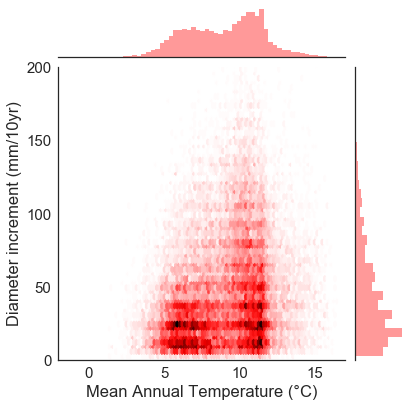

In [28]:
sns.set(font_scale=1.5)
with sns.axes_style("white"): 
    g = sns.jointplot(x=df.MAT, y=df.diamincr_mm, kind="hex", stat_func=None, color="r")
    g.ax_joint.set_xlim(-2, 17)
    g.ax_joint.set_ylim(0,200)
    g.ax_joint.set_yticks([0,50,100,150,200])
    g.ax_joint.set_ylabel('Diameter increment (mm/10yr)')
    g.ax_joint.set_xlabel(u'Mean Annual Temperature (\u00B0C)')
    g.ax_joint.set_xticks([0,5,10,15])
    g.savefig('MAT2.png');

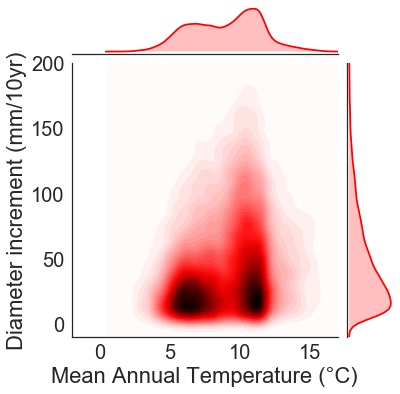

In [42]:
sns.set(font_scale=2.0)
with sns.axes_style("white"): 
    g = sns.jointplot(x=df.MAT, y=df.diamincr_mm, kind="kde", stat_func=None, color="r", joint_kws={'n_levels':50})
    g.ax_joint.set_xlim(-2, 17)
    g.ax_joint.set_ylim(-10,200)
    g.ax_joint.set_yticks([0,50,100,150,200])
    g.ax_joint.set_ylabel('Diameter increment (mm/10yr)')
    g.ax_joint.set_xlabel(u'Mean Annual Temperature (\u00B0C)')
    g.ax_joint.set_xticks([0,5,10,15])
    g.savefig('MAT1.png');